#### Load both datasets and do a strict “data audit”

In [ ]:
# --- Step 1: Setup & Data Audit ---

import pandas as pd
import numpy as np

# >>>> UPDATE THESE if your files live elsewhere <<<<
PATH_D1 = "SN-dataset1.csv"     # per-landing events
PATH_D2 = "1X-dataset2.csv"     # 30-min windows

pd.set_option("display.width", 140)
pd.set_option("display.max_columns", 200)

# Parse datetimes robustly
parse_dates_d1 = ["start_time", "rat_period_start", "rat_period_end", "sunset_time"]
parse_dates_d2 = ["time"]

def read_csv_safely(path, parse_dates=None):
    try:
        return pd.read_csv(path, parse_dates=parse_dates, infer_datetime_format=True, dayfirst=False)
    except Exception as e:
        print(f"[LOAD ERROR] {path}: {e}")
        raise

d1 = read_csv_safely(PATH_D1, parse_dates=parse_dates_d1)
d2 = read_csv_safely(PATH_D2, parse_dates=parse_dates_d2)

def audit_df(df: pd.DataFrame, name: str):
    print(f"\n================= AUDIT: {name} =================")
    print("Shape:", df.shape)
    print("Columns:", list(df.columns))
    print("\nDtypes:")
    print(df.dtypes)
    print("\nMissing values (top 25):")
    print(df.isna().sum().sort_values(ascending=False).head(25))
    print("\nHead:")
    print(df.head(3))
    print("\nTail:")
    print(df.tail(3))
    # Numeric describe
    num = df.select_dtypes(include=[np.number])
    if not num.empty:
        print("\nNumeric summary:")
        print(num.describe().T)
    # Datetime min/max
    dt_cols = df.select_dtypes(include=["datetime64[ns]", "datetime64[ns, UTC]"]).columns
    for c in dt_cols:
        print(f"\nDatetime range [{c}]:", df[c].min(), "->", df[c].max())

print(">>> Basic audits")
audit_df(d1, "Dataset1 (SN-dataset1)")
audit_df(d2, "Dataset2 (1X-dataset2)")

# Sanity checks specific to this project
print("\n>>> Sanity checks")
for col in ["risk", "reward"]:
    if col in d1.columns:
        print(f"\nValue counts for {col} in D1:")
        print(d1[col].value_counts(dropna=False).sort_index())

if "season" in d1.columns:
    print("\nUnique seasons in D1:", sorted(d1["season"].dropna().unique().tolist()))
if "month" in d1.columns:
    print("Unique months in D1 (first 20):", sorted(d1["month"].dropna().unique().tolist())[:20])
if "month" in d2.columns:
    print("Unique months in D2 (first 20):", sorted(d2["month"].dropna().unique().tolist())[:20])

# Check for duplicates where it matters
if "time" in d2.columns:
    dup_d2 = d2.duplicated(subset=["time"]).sum()
    print("\nDuplicate 30-min windows in D2 (by 'time'):", dup_d2)

# Keep raw copies for future steps
d1_raw = d1.copy()
d2_raw = d2.copy()

print("\n[Step 1 complete] Paste everything printed above here.")


>>> Basic audits

================= AUDIT: Dataset1 (SN-dataset1) =================
Shape: (907, 12)
Columns: ['start_time', 'bat_landing_to_food', 'habit', 'rat_period_start', 'rat_period_end', 'seconds_after_rat_arrival', 'risk', 'reward', 'month', 'sunset_time', 'hours_after_sunset', 'season']

Dtypes:
start_time                   datetime64[ns]
bat_landing_to_food                 float64
habit                                object
rat_period_start             datetime64[ns]
rat_period_end               datetime64[ns]
seconds_after_rat_arrival             int64
risk                                  int64
reward                                int64
month                                 int64
sunset_time                  datetime64[ns]
hours_after_sunset                  float64
season                                int64
dtype: object

Missing values (top 25):
habit                        41
start_time                    0
bat_landing_to_food           0
rat_period_start             

/tmp/ipython-input-2972374633.py:19: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  return pd.read_csv(path, parse_dates=parse_dates, infer_datetime_format=True, dayfirst=False)
/tmp/ipython-input-2972374633.py:19: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  return pd.read_csv(path, parse_dates=parse_dates, infer_datetime_format=True, dayfirst=False)
/tmp/ipython-input-2972374633.py:19: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  return pd.read_csv(path, parse_dates=parse_dates, infer_datetime_format=True, dayfirst=False)
/t

#### data cleaning + canonical features

In [ ]:
# --- Step 2: Light cleaning + canonical features (on Dataset1) ---

import numpy as np
import pandas as pd

d1 = d1.copy()  # work on a copy

print(">>> Cleaning 'habit' and creating canonical features")

# 1) Clean 'habit'
# - Fill NA with 'unknown'
# - Lowercase, strip
# - Collapse noisy coordinate-like tokens and oddities into 'other'
d1['habit'] = d1['habit'].fillna('unknown').astype(str).str.strip().str.lower()

# patterns that look like coordinates or junk (e.g., "73.2,17.1", "x123,456", etc.)
coord_like = d1['habit'].str.contains(r'^\s*[-+]?\d+(\.\d+)?\s*,\s*[-+]?\d+(\.\d+)?\s*$', regex=True)
weird_tokens = d1['habit'].isin(['nan', 'none', 'null', 'na', ''])  # just in case

d1['habit_clean'] = d1['habit']
d1.loc[coord_like | weird_tokens, 'habit_clean'] = 'other'

print("\nHabit value counts (raw top 15):")
print(d1['habit'].value_counts().head(15))
print("\nHabit value counts (clean top 15):")
print(d1['habit_clean'].value_counts().head(15))

# 2) Canonical features

# (a) Landing after rat arrival (strictly > 0 sec)
d1['landing_after_rat'] = (d1['seconds_after_rat_arrival'] > 0).astype(int)

# (b) Did landing occur during the recorded rat period window?
#     start_time in [rat_period_start, rat_period_end]
d1['rat_presence_window'] = (
    (d1['start_time'] >= d1['rat_period_start']) &
    (d1['start_time'] <= d1['rat_period_end'])
).astype(int)

# (c) Time difference to rat period start/end (seconds): helps later modeling if needed
d1['secs_to_rat_start'] = (d1['start_time'] - d1['rat_period_start']).dt.total_seconds()
d1['secs_to_rat_end']   = (d1['rat_period_end'] - d1['start_time']).dt.total_seconds()

# (d) Bins for seconds_after_rat_arrival — interpretability in plots/tables
bins = [-np.inf, 0, 60, 180, 360, 600, np.inf]
labels = ['<=0s', '0-1m', '1-3m', '3-6m', '6-10m', '>10m']
d1['sec_after_rat_bin'] = pd.cut(d1['seconds_after_rat_arrival'], bins=bins, labels=labels, right=True)

# Quick sanity checks
print("\n>>> Sanity checks for new features")
for col in ['landing_after_rat', 'rat_presence_window', 'sec_after_rat_bin']:
    print(f"{col} missing:", d1[col].isna().sum())
print("Unique labels in 'sec_after_rat_bin':", d1['sec_after_rat_bin'].unique().tolist())

# 3) Basic relationships with risk/reward

def show_rate_table(flag_col, target='risk'):
    tab = (d1.groupby(flag_col)[target]
             .agg(['count', 'mean'])
             .rename(columns={'mean': f'{target}_rate'})
             .reset_index())
    return tab

print("\nRisk vs landing_after_rat:")
print(show_rate_table('landing_after_rat', 'risk').round(3))

print("\nReward vs landing_after_rat:")
print(show_rate_table('landing_after_rat', 'reward').round(3))

print("\nRisk vs rat_presence_window:")
print(show_rate_table('rat_presence_window', 'risk').round(3))

print("\nReward vs rat_presence_window:")
print(show_rate_table('rat_presence_window', 'reward').round(3))

# Crosstabs with bins
print("\nRisk rate by sec_after_rat_bin:")
risk_by_bin = d1.pivot_table(index='sec_after_rat_bin', values='risk', aggfunc='mean')
print(risk_by_bin.round(3))

print("\nReward rate by sec_after_rat_bin:")
reward_by_bin = d1.pivot_table(index='sec_after_rat_bin', values='reward', aggfunc='mean')
print(reward_by_bin.round(3))

print("\n[Step 2 complete] Paste everything printed above here.")

>>> Cleaning 'habit' and creating canonical features

Habit value counts (raw top 15):
habit
fast               245
rat                221
pick               139
unknown             41
bat                 30
bat_fight           26
bat_and_pick        20
bat_and_rat         19
rat_pick            14
rat_and_bat         14
pick_and_bat         8
pick_and_others      8
rat_and_pick         8
bats                 7
other_bats           7
Name: count, dtype: int64

Habit value counts (clean top 15):
habit_clean
fast               245
rat                221
pick               139
unknown             41
bat                 30
bat_fight           26
bat_and_pick        20
bat_and_rat         19
rat_pick            14
rat_and_bat         14
pick_and_bat         8
pick_and_others      8
rat_and_pick         8
bats                 7
other_bats           7
Name: count, dtype: int64

>>> Sanity checks for new features
landing_after_rat missing: 0
rat_presence_window missing: 0
sec_after_rat_bin mis

/tmp/ipython-input-708995722.py:17: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  coord_like = d1['habit'].str.contains(r'^\s*[-+]?\d+(\.\d+)?\s*,\s*[-+]?\d+(\.\d+)?\s*$', regex=True)
/tmp/ipython-input-708995722.py:78: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  risk_by_bin = d1.pivot_table(index='sec_after_rat_bin', values='risk', aggfunc='mean')
/tmp/ipython-input-708995722.py:82: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  reward_by_bin = d1.pivot_table(index='sec_after_rat_bin', values='reward', aggfunc='mean')


#### Join bat landings to 30-min windows (dataset2)

In [ ]:
# ============================================
# Step 3 — Join landing events (d1) to 30-min windows (d2)
# ============================================
# Assumes Step 1 already created: d1 (SN-dataset1), d2 (1X-dataset2)

import pandas as pd
import numpy as np

# --- Work on copies ---
d1_join = d1.copy()
d2_join = d2.copy().sort_values("time").copy()

# --- Rename d2 columns UP FRONT to avoid merge collisions ---
d2_join = d2_join.rename(columns={
    "time": "win_time",
    "hours_after_sunset": "win_hours_after_sunset",
    "bat_landing_number": "win_bat_landing_number",
    "food_availability": "win_food_availability",
    "rat_minutes": "win_rat_minutes",
    "rat_arrival_number": "win_rat_arrivals",
})

# --- Define each 30-min window end ---
d2_join["window_end"] = d2_join["win_time"] + pd.Timedelta(minutes=30)

# --- As-of merge: for each start_time, find prior window start (<= start_time) ---
joined = pd.merge_asof(
    d1_join.sort_values("start_time"),
    d2_join.sort_values("win_time"),
    left_on="start_time",
    right_on="win_time",
    direction="backward",
    tolerance=pd.Timedelta(minutes=30)
)

# --- Keep only landings strictly inside the window [win_time, window_end) ---
mask_in_window = (joined["start_time"] >= joined["win_time"]) & (joined["start_time"] < joined["window_end"])
pre_count = len(joined)
joined = joined.loc[mask_in_window].copy()
post_count = len(joined)

# --- Diagnostics ---
print(">>> Join diagnostics")
print("Rows in d1:", len(d1_join))
print("Rows after asof match (before window filter):", pre_count)
print("Rows retained inside [win_time, window_end):", post_count)
print("Unmatched or out-of-window rows:", len(d1_join) - post_count)

# --- Month coverage (derive if missing) ---
if "month" in joined.columns:
    joined["month_d1"] = joined["month"]
else:
    month_map = {12:0, 1:1, 2:2, 3:3, 4:4, 5:5, 6:6}
    joined["month_d1"] = joined["start_time"].dt.month.map(month_map)

print("\nColumns in joined:")
print(sorted(joined.columns.tolist()))

# --- Coverage by month (compare to original d1) ---
d1_month_counts = d1_join.groupby("month").size().rename("total_rows_d1_month")
coverage = (joined.assign(joined_flag=1)
            .groupby("month_d1")[["joined_flag"]]
            .count()
            .rename(columns={"joined_flag":"matched_rows"})
            .join(d1_month_counts, how="left"))
coverage["match_rate"] = coverage["matched_rows"] / coverage["total_rows_d1_month"]
print("\nMatch coverage by month_d1:")
print(coverage)

# --- Sanity: temporal alignment ---
viol_low = (joined["start_time"] < joined["win_time"]).sum()
viol_high = (joined["start_time"] >= joined["window_end"]).sum()
print("\nTemporal violations -> start_time < win_time:", viol_low, "| start_time >= window_end:", viol_high)

# --- Unique windows referenced ---
print("\nUnique 30-min windows referenced:", joined["win_time"].nunique())

# --- Quick view of key columns actually present ---
cols_to_show = [
    "start_time", "win_time", "window_end",
    "hours_after_sunset", "win_hours_after_sunset",
    "win_rat_minutes", "win_rat_arrivals",
    "win_food_availability", "win_bat_landing_number",
    "risk", "reward", "sec_after_rat_bin", "month_d1", "season"
]
cols_to_show = [c for c in cols_to_show if c in joined.columns]
print("\nHead (selected cols):")
print(joined[cols_to_show].head(8))

# --- Quick relationships using quartiles of rat minutes ---
def qcut_series(s, q=4, label_prefix="Q"):
    uniq = np.unique(s[~pd.isna(s)])
    if len(uniq) < q:
        return pd.cut(s, bins=min(len(uniq), q), include_lowest=True)
    return pd.qcut(s, q=q, duplicates="drop", labels=[f"{label_prefix}{i}" for i in range(1, q+1)])

joined["rat_minutes_q"] = qcut_series(joined["win_rat_minutes"], q=4, label_prefix="RM")

print("\nRisk rate by rat_minutes quartile:")
print(joined.groupby("rat_minutes_q")["risk"].mean().round(3))

print("\nReward rate by rat_minutes quartile:")
print(joined.groupby("rat_minutes_q")["reward"].mean().round(3))

print("\n[Step 3 complete]")

# --- Keep for next steps (NO trailing comma!) ---
d_joined = joined.copy()


>>> Join diagnostics
Rows in d1: 907
Rows after asof match (before window filter): 907
Rows retained inside [win_time, window_end): 907
Unmatched or out-of-window rows: 0

Columns in joined:
['bat_landing_to_food', 'habit', 'habit_clean', 'hours_after_sunset', 'landing_after_rat', 'month_d1', 'month_x', 'month_y', 'rat_period_end', 'rat_period_start', 'rat_presence_window', 'reward', 'risk', 'season', 'sec_after_rat_bin', 'seconds_after_rat_arrival', 'secs_to_rat_end', 'secs_to_rat_start', 'start_time', 'sunset_time', 'win_bat_landing_number', 'win_food_availability', 'win_hours_after_sunset', 'win_rat_arrivals', 'win_rat_minutes', 'win_time', 'window_end']

Match coverage by month_d1:
          matched_rows  total_rows_d1_month  match_rate
month_d1                                               
0                   26                   26         1.0
1                   33                   33         1.0
2                   92                   92         1.0
3                   26   

/tmp/ipython-input-711905881.py:100: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(joined.groupby("rat_minutes_q")["risk"].mean().round(3))
/tmp/ipython-input-711905881.py:103: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(joined.groupby("rat_minutes_q")["reward"].mean().round(3))


#### Descriptive analysis

/tmp/ipython-input-1540274447.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return df.groupby(col)[target].agg(['count','mean']).rename(columns={'mean':f'{target}_rate'})
/tmp/ipython-input-1540274447.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return df.groupby(col)[target].agg(['count','mean']).rename(columns={'mean':f'{target}_rate'})


Risk vs rat_minutes quartile:
                count  risk_rate
rat_minutes_q                  
Q1               237      0.540
Q2               217      0.465
Q3               236      0.466
Q4               217      0.507 

Reward vs rat_minutes quartile:
                count  reward_rate
rat_minutes_q                    
Q1               237        0.468
Q2               217        0.567
Q3               236        0.551
Q4               217        0.553 



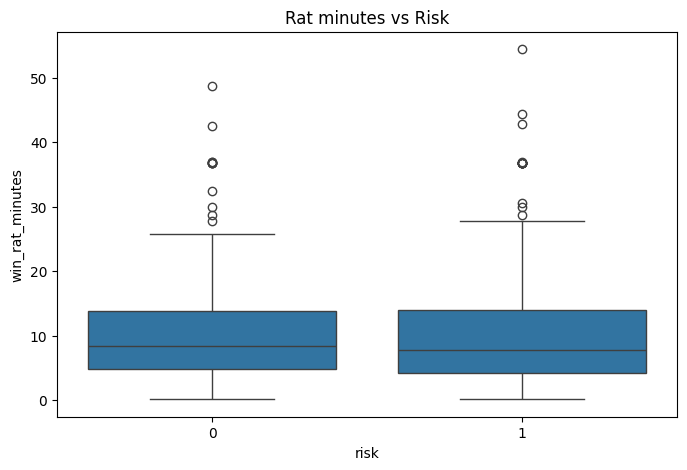

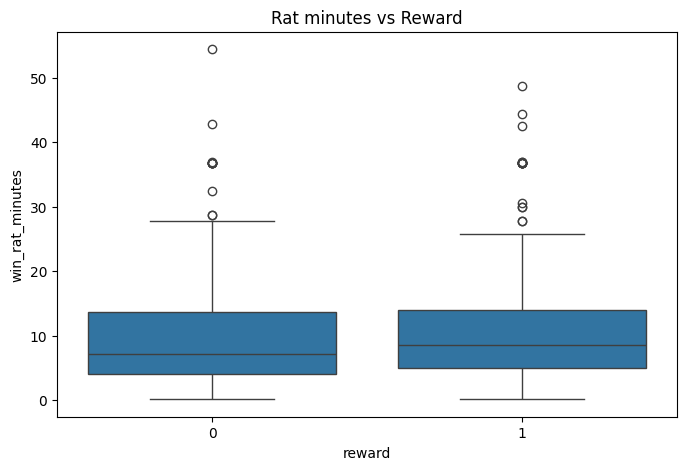

Risk vs rat_arrivals_bin:
                   count  risk_rate
rat_arrivals_bin                  
0                     0        NaN
1                   518      0.485
2-3                 306      0.487
4-10                 80      0.600
>10                   3      0.333 

Reward vs rat_arrivals_bin:
                   count  reward_rate
rat_arrivals_bin                    
0                     0          NaN
1                   518        0.552
2-3                 306        0.559
4-10                 80        0.338
>10                   3        0.000 



/tmp/ipython-input-1540274447.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return df.groupby(col)[target].agg(['count','mean']).rename(columns={'mean':f'{target}_rate'})
/tmp/ipython-input-1540274447.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return df.groupby(col)[target].agg(['count','mean']).rename(columns={'mean':f'{target}_rate'})
/tmp/ipython-input-1540274447.py:35: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='rat_arrivals_bin', y='risk', data=j, ci=None)


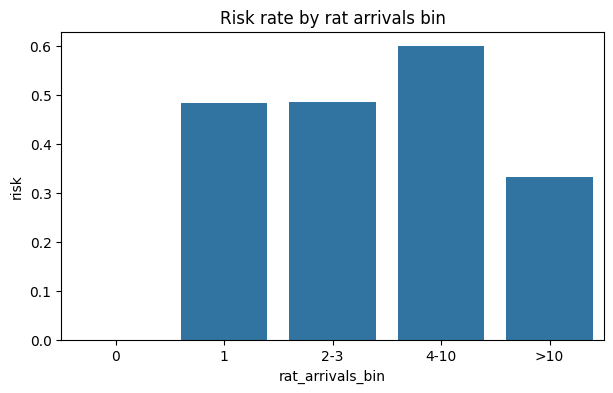

/tmp/ipython-input-1540274447.py:40: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='rat_arrivals_bin', y='reward', data=j, ci=None)


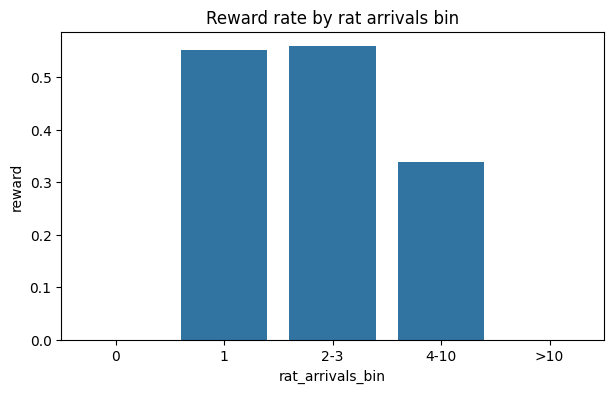

/tmp/ipython-input-1540274447.py:50: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='food_bin', y='risk', data=j, ci=None, marker="o")


Risk vs food_bin:
           count  risk_rate
food_bin                  
0.0          16      0.375
1.0          55      0.418
1.5          33      0.455
2.0         275      0.458
2.5          53      0.604
3.0         409      0.543
3.5          18      0.278
4.0          48      0.417 

Reward vs food_bin:
           count  reward_rate
food_bin                    
0.0          16        0.625
1.0          55        0.564
1.5          33        0.515
2.0         275        0.567
2.5          53        0.566
3.0         409        0.499
3.5          18        0.500
4.0          48        0.562 



/tmp/ipython-input-1540274447.py:51: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='food_bin', y='reward', data=j, ci=None, marker="o")


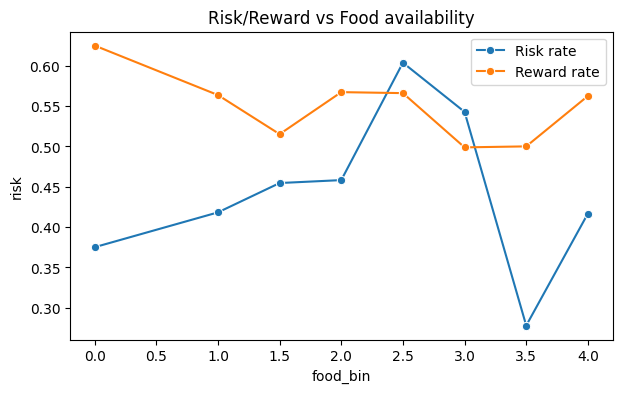

/tmp/ipython-input-1540274447.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return df.groupby(col)[target].agg(['count','mean']).rename(columns={'mean':f'{target}_rate'})
/tmp/ipython-input-1540274447.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return df.groupby(col)[target].agg(['count','mean']).rename(columns={'mean':f'{target}_rate'})
/tmp/ipython-input-1540274447.py:62: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='hours_bin', y='risk', data=j, ci=None)
/tmp/ipython-input-1540274447.py:63: FutureWarning: 

The `ci` parameter i

Risk vs hours_bin:
            count  risk_rate
hours_bin                  
0-2           99      0.525
2-4          202      0.535
4-6          262      0.504
6-8          259      0.444
8-10          77      0.519
>10            8      0.250 

Reward vs hours_bin:
            count  reward_rate
hours_bin                    
0-2           99        0.495
2-4          202        0.505
4-6          262        0.523
6-8          259        0.583
8-10          77        0.519
>10            8        0.625 



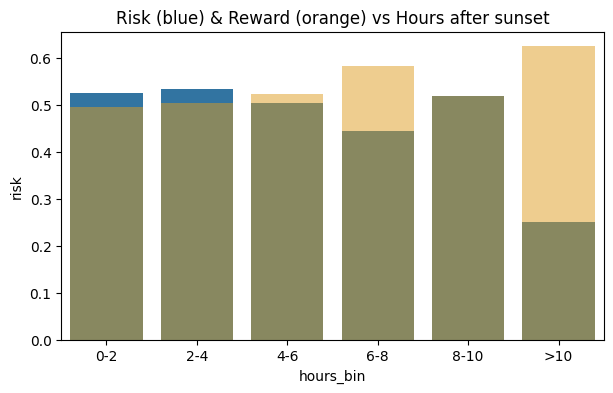

Risk vs season:
         count  risk_rate
season                  
0         151      0.563
1         756      0.481 

Reward vs season:
         count  reward_rate
season                    
0         151        0.364
1         756        0.567 



/tmp/ipython-input-1540274447.py:72: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='season', y='risk', data=j, ci=None)
/tmp/ipython-input-1540274447.py:73: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='season', y='reward', data=j, ci=None, color='orange', alpha=0.5)


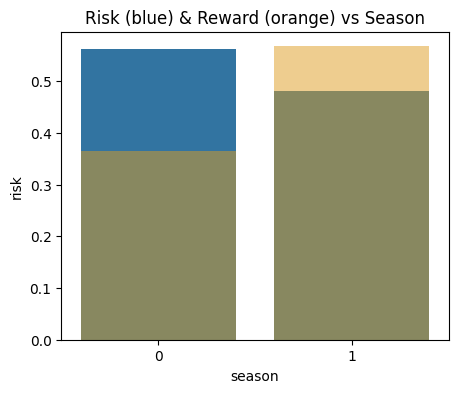


[Step 4 complete — paste text + plots here]


In [ ]:
# --- Step 4: Descriptive analysis ---

import matplotlib.pyplot as plt
import seaborn as sns

j = d_joined.copy()

# Helper: summarize rate by bins
def summarize_rate(df, col, target):
    return df.groupby(col)[target].agg(['count','mean']).rename(columns={'mean':f'{target}_rate'})

# 1) Rat pressure: quartiles
j['rat_minutes_q'] = pd.qcut(j['win_rat_minutes'], q=4, duplicates='drop', labels=['Q1','Q2','Q3','Q4'])
print("Risk vs rat_minutes quartile:\n", summarize_rate(j,'rat_minutes_q','risk').round(3), "\n")
print("Reward vs rat_minutes quartile:\n", summarize_rate(j,'rat_minutes_q','reward').round(3), "\n")

# Plot risk/reward vs rat_minutes
plt.figure(figsize=(8,5))
sns.boxplot(x='risk', y='win_rat_minutes', data=j)
plt.title("Rat minutes vs Risk")
plt.show()

plt.figure(figsize=(8,5))
sns.boxplot(x='reward', y='win_rat_minutes', data=j)
plt.title("Rat minutes vs Reward")
plt.show()

# 2) Rat arrivals
j['rat_arrivals_bin'] = pd.cut(j['win_rat_arrivals'], bins=[-1,0,1,3,10,100], labels=['0','1','2-3','4-10','>10'])
print("Risk vs rat_arrivals_bin:\n", summarize_rate(j,'rat_arrivals_bin','risk').round(3), "\n")
print("Reward vs rat_arrivals_bin:\n", summarize_rate(j,'rat_arrivals_bin','reward').round(3), "\n")

# Barplot
plt.figure(figsize=(7,4))
sns.barplot(x='rat_arrivals_bin', y='risk', data=j, ci=None)
plt.title("Risk rate by rat arrivals bin")
plt.show()

plt.figure(figsize=(7,4))
sns.barplot(x='rat_arrivals_bin', y='reward', data=j, ci=None)
plt.title("Reward rate by rat arrivals bin")
plt.show()

# 3) Food availability (round to 0.5 bins)
j['food_bin'] = (j['win_food_availability']*2).round()/2
print("Risk vs food_bin:\n", summarize_rate(j,'food_bin','risk').round(3), "\n")
print("Reward vs food_bin:\n", summarize_rate(j,'food_bin','reward').round(3), "\n")

plt.figure(figsize=(7,4))
sns.lineplot(x='food_bin', y='risk', data=j, ci=None, marker="o")
sns.lineplot(x='food_bin', y='reward', data=j, ci=None, marker="o")
plt.title("Risk/Reward vs Food availability")
plt.legend(['Risk rate','Reward rate'])
plt.show()

# 4) Hours after sunset: bin into categories
j['hours_bin'] = pd.cut(j['win_hours_after_sunset'], bins=[-1,2,4,6,8,10,15], labels=['0-2','2-4','4-6','6-8','8-10','>10'])
print("Risk vs hours_bin:\n", summarize_rate(j,'hours_bin','risk').round(3), "\n")
print("Reward vs hours_bin:\n", summarize_rate(j,'hours_bin','reward').round(3), "\n")

plt.figure(figsize=(7,4))
sns.barplot(x='hours_bin', y='risk', data=j, ci=None)
sns.barplot(x='hours_bin', y='reward', data=j, ci=None, color='orange', alpha=0.5)
plt.title("Risk (blue) & Reward (orange) vs Hours after sunset")
plt.show()

# 5) Season
print("Risk vs season:\n", summarize_rate(j,'season','risk').round(3), "\n")
print("Reward vs season:\n", summarize_rate(j,'season','reward').round(3), "\n")

plt.figure(figsize=(5,4))
sns.barplot(x='season', y='risk', data=j, ci=None)
sns.barplot(x='season', y='reward', data=j, ci=None, color='orange', alpha=0.5)
plt.title("Risk (blue) & Reward (orange) vs Season")
plt.show()

print("\n[Step 4 complete — paste text + plots here]")

#### (EDA with joined rat pressure variables)

/tmp/ipython-input-1723533382.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(col)[target]
/tmp/ipython-input-1723533382.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(col)[target]
/tmp/ipython-input-1723533382.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(col)[target]
/tmp/ipython-input-1723533382.py:7: FutureWarning: The default of observed=False is deprecated and will be

Risk vs rat_minutes quartile:
                count  risk_rate
rat_minutes_q                  
Q1               237   0.540084
Q2               217   0.465438
Q3               236   0.466102
Q4               217   0.506912

Reward vs rat_minutes quartile:
                count  reward_rate
rat_minutes_q                    
Q1               237     0.468354
Q2               217     0.566820
Q3               236     0.550847
Q4               217     0.552995

Risk vs rat_arrivals_bin:
                   count  risk_rate
rat_arrivals_bin                  
1                   518   0.484556
2-3                 306   0.486928
4-10                 80   0.600000
>10                   3   0.333333

Reward vs rat_arrivals_bin:
                   count  reward_rate
rat_arrivals_bin                    
1                   518     0.552124
2-3                 306     0.558824
4-10                 80     0.337500
>10                   3     0.000000

Risk vs food_bin:
           count  risk_rate
fo

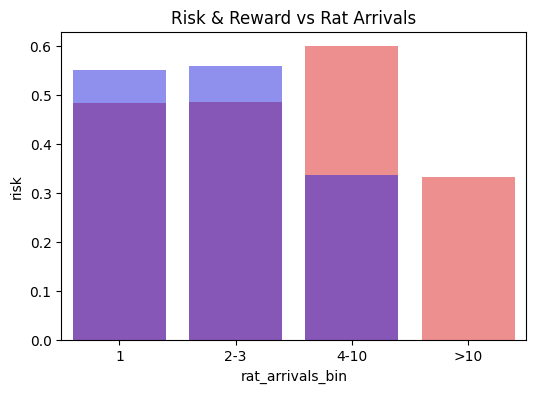

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Helper: summarize risk & reward rates
def summarize_rates(df, col, target="risk"):
    return (
        df.groupby(col)[target]
        .agg(['count','mean'])
        .rename(columns={'mean':f'{target}_rate'})
    )

# ------------------------
# 1) Rat minutes quartiles
# ------------------------
d_joined["rat_minutes_q"] = pd.qcut(
    d_joined["win_rat_minutes"], q=4, labels=["Q1","Q2","Q3","Q4"]
)

print("Risk vs rat_minutes quartile:\n", summarize_rates(d_joined, "rat_minutes_q", "risk"))
print("\nReward vs rat_minutes quartile:\n", summarize_rates(d_joined, "rat_minutes_q", "reward"))

# ------------------------
# 2) Rat arrivals bins
# ------------------------
bins = [-0.1,1,3,10,100]
labels = ["1","2-3","4-10",">10"]
d_joined["rat_arrivals_bin"] = pd.cut(d_joined["win_rat_arrivals"], bins=bins, labels=labels)

print("\nRisk vs rat_arrivals_bin:\n", summarize_rates(d_joined, "rat_arrivals_bin", "risk"))
print("\nReward vs rat_arrivals_bin:\n", summarize_rates(d_joined, "rat_arrivals_bin", "reward"))

# ------------------------
# 3) Food availability bins
# ------------------------
d_joined["food_bin"] = d_joined["win_food_availability"].round(1)
print("\nRisk vs food_bin:\n", summarize_rates(d_joined, "food_bin", "risk"))
print("\nReward vs food_bin:\n", summarize_rates(d_joined, "food_bin", "reward"))

# ------------------------
# 4) Hours after sunset bins
# ------------------------
bins = [0,2,4,6,8,10,99]
labels = ["0-2","2-4","4-6","6-8","8-10",">10"]
d_joined["hours_bin"] = pd.cut(d_joined["win_hours_after_sunset"], bins=bins, labels=labels)

print("\nRisk vs hours_bin:\n", summarize_rates(d_joined, "hours_bin", "risk"))
print("\nReward vs hours_bin:\n", summarize_rates(d_joined, "hours_bin", "reward"))

# ------------------------
# 5) Season
# ------------------------
print("\nRisk vs season:\n", summarize_rates(d_joined, "season", "risk"))
print("\nReward vs season:\n", summarize_rates(d_joined, "season", "reward"))

# ------------------------
# Example plot (rat arrivals vs risk/reward)
# ------------------------
plt.figure(figsize=(6,4))
sns.barplot(x="rat_arrivals_bin", y="risk", data=d_joined, color="red", alpha=0.5, ci=None)
sns.barplot(x="rat_arrivals_bin", y="reward", data=d_joined, color="blue", alpha=0.5, ci=None)
plt.title("Risk & Reward vs Rat Arrivals")
plt.show()

#### inferential analysis (logistic Regression)

In [ ]:
# ============================================
# Step 5 — Inferential Analysis (Logistic Regression)
# ============================================

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# ---------- Helpers ----------

def build_model_frame(d_joined: pd.DataFrame) -> pd.DataFrame:
    """Selects columns, applies log1p to skewed counts, z-scores continuous predictors."""
    df = d_joined[[
        "risk","reward","season",
        "win_rat_minutes","win_rat_arrivals","win_food_availability","win_hours_after_sunset"
    ]].dropna().copy()

    # Skewed counts -> log1p
    df["rat_minutes_log1p"]   = np.log1p(df["win_rat_minutes"])
    df["rat_arrivals_log1p"]  = np.log1p(df["win_rat_arrivals"])

    # Z-score continuous predictors
    cont_cols = ["rat_minutes_log1p","rat_arrivals_log1p","win_food_availability","win_hours_after_sunset"]
    scaler = StandardScaler()
    df[[c+"_z" for c in cont_cols]] = scaler.fit_transform(df[cont_cols])

    return df, cont_cols

def fit_logit(y, X):
    """Fits Logit with HC3 robust SEs and returns fitted results."""
    model = sm.Logit(y.astype(int), sm.add_constant(X))
    res = model.fit(disp=False, cov_type="HC3")
    return res

def or_table(res):
    """Creates an Odds Ratio table with robust SEs and 95% CI."""
    params = res.params
    conf = res.conf_int()
    se = res.bse
    out = pd.DataFrame({
        "coef": params,
        "robust_se": se,
        "z": params / se,
        "pval": res.pvalues,
        "OR": np.exp(params),
        "OR_low": np.exp(conf[0]),
        "OR_high": np.exp(conf[1]),
    })
    return out

def mcfadden_r2(res):
    """McFadden pseudo-R²."""
    return 1 - (res.llf / res.llnull)

def vif_table(df_for_vif: pd.DataFrame) -> pd.DataFrame:
    """Computes VIF for predictors."""
    X_vif = sm.add_constant(df_for_vif)
    rows = []
    for i, col in enumerate(X_vif.columns):
        if col == "const":
            continue
        rows.append({"feature": col, "VIF": variance_inflation_factor(X_vif.values, i)})
    return pd.DataFrame(rows)

# ---------- Build data ----------
df, cont_cols = build_model_frame(d_joined)

X_base = df[[c+"_z" for c in cont_cols] + ["season"]].copy()
y_risk   = df["risk"]
y_reward = df["reward"]

# ---------- Fit models ----------
res_risk   = fit_logit(y_risk,   X_base)
res_reward = fit_logit(y_reward, X_base)

# ---------- Print results ----------
print("=== Logistic Model: RISK ~ rat pressure + food + time + season ===")
print(or_table(res_risk).round(3))
print("McFadden pseudo-R²:", round(mcfadden_r2(res_risk), 3))
print("ROC AUC (risk):", round(roc_auc_score(y_risk, res_risk.predict()), 3))

print("\n=== Logistic Model: REWARD ~ rat pressure + food + time + season ===")
print(or_table(res_reward).round(3))
print("McFadden pseudo-R²:", round(mcfadden_r2(res_reward), 3))
print("ROC AUC (reward):", round(roc_auc_score(y_reward, res_reward.predict()), 3))

# ---------- Multicollinearity (VIF) ----------
vif_df = df[["rat_minutes_log1p","rat_arrivals_log1p","win_food_availability","win_hours_after_sunset","season"]].copy()
print("\n=== VIF (multicollinearity check) ===")
print(vif_table(vif_df).round(3))

# ---------- Interaction model ----------
# Uncomment below to test interaction of rat pressure × season
X_inter = X_base.copy()
X_inter["rat_minutes_x_season"]  = X_inter["rat_minutes_log1p_z"] * X_inter["season"]
X_inter["rat_arrivals_x_season"] = X_inter["rat_arrivals_log1p_z"] * X_inter["season"]
res_risk_inter   = fit_logit(y_risk,   X_inter)
res_reward_inter = fit_logit(y_reward, X_inter)
print("\n=== RISK with interactions ===")
print(or_table(res_risk_inter).round(3))
print("McFadden R²:", round(mcfadden_r2(res_risk_inter), 3), " | AUC:", round(roc_auc_score(y_risk, res_risk_inter.predict()), 3))
print("\n=== REWARD with interactions ===")
print(or_table(res_reward_inter).round(3))
print("McFadden R²:", round(mcfadden_r2(res_reward_inter), 3), " | AUC:", round(roc_auc_score(y_reward, res_reward_inter.predict()), 3))


=== Logistic Model: RISK ~ rat pressure + food + time + season ===
                           coef  robust_se      z   pval     OR  OR_low  OR_high
const                     0.246      0.179  1.375  0.169  1.278   0.901    1.815
rat_minutes_log1p_z       0.011      0.075  0.153  0.878  1.012   0.873    1.172
rat_arrivals_log1p_z      0.071      0.071  0.996  0.319  1.073   0.934    1.233
win_food_availability_z   0.041      0.093  0.443  0.658  1.042   0.869    1.250
win_hours_after_sunset_z -0.097      0.094 -1.028  0.304  0.908   0.755    1.092
season                   -0.318      0.198 -1.606  0.108  0.728   0.494    1.073
McFadden pseudo-R²: 0.006
ROC AUC (risk): 0.556

=== Logistic Model: REWARD ~ rat pressure + food + time + season ===
                           coef  robust_se      z   pval     OR  OR_low  OR_high
const                    -0.419      0.182 -2.298  0.022  0.657   0.460    0.940
rat_minutes_log1p_z       0.121      0.076  1.604  0.109  1.129   0.973    1.310
rat_a